# Exploratory Analysis

* $RQ_1$: How does temporal proximity affect sharing behaviour during protest demonstrations?
* $RQ_2$: How do source attributes like the poster's gender affect sharing behaviour during protest demonstrations?


In [15]:
library(lme4)
library(AER)
library(dplyr)
library(purrr)
library(magrittr)
library(ggplot2)
require(GGally)
require(reshape2)
require(compiler)
require(parallel)
require(boot)
require(lattice)

data <- read.csv("../../data/processed/607d6b3929befce813fe5ba2-rumour-results.csv")
data$reshared <- as.integer(as.logical(data$reshared))
head(data)

,user_id,condition,timeSubmitted,secondsTaken,id,rumour,code,evidence,warning,reshared,clickedWarning,timestamp,mockGender
,<dbl>,<chr>,<chr>,<int>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>
1,7.057603e+18,treatment,2021-05-24 10:57:41.980000+00:00,120,1.283487e+18,R1,denies,high,True,1,False,2,female
2,7.057603e+18,treatment,2021-05-24 10:57:41.980000+00:00,120,1.284272e+18,R1,neutral,high,False,0,False,2,female
3,7.057603e+18,treatment,2021-05-24 10:57:41.980000+00:00,120,1.283527e+18,R1,questions,high,False,1,False,4,female
4,7.057603e+18,treatment,2021-05-24 10:57:41.980000+00:00,120,1.283565e+18,R1,denies,high,True,1,True,5,female
5,7.057603e+18,treatment,2021-05-24 10:57:41.980000+00:00,120,1.283799e+18,R1,questions,high,False,0,False,6,male
6,7.057603e+18,treatment,2021-05-24 10:57:41.980000+00:00,120,1.283523e+18,R1,affirms,high,False,1,False,7,male


In [57]:
# md <- lmer(Affirms ~ condition * evidence + (1 | user_id), data = data)
md <- glmer(reshared ~ mockGender + timestamp + warning + (1 + condition |user_id) + (1 | rumour), #, 
            data = data,
            family = binomial )
summary(md)

boundary (singular) fit: see ?isSingular



Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: reshared ~ mockGender + timestamp + warning + (1 + condition |  
    user_id) + (1 | rumour)
   Data: data

     AIC      BIC   logLik deviance df.resid 
   342.4    375.2   -163.2    326.4      440 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-1.1757 -0.4284 -0.2844 -0.1885  5.0595 

Random effects:
 Groups  Name               Variance Std.Dev. Corr 
 user_id (Intercept)        0.4946   0.7033        
         conditiontreatment 0.7034   0.8387   -0.17
 rumour  (Intercept)        0.0000   0.0000        
Number of obs: 448, groups:  user_id, 8; rumour, 2

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)    -1.025833   0.446157  -2.299   0.0215 *  
mockGendermale  0.034341   0.292428   0.117   0.9065    
timestamp      -0.039923   0.009254  -4.314  1.6e-05 ***
warningTrue    -0.814897   0.526687  -1.547   

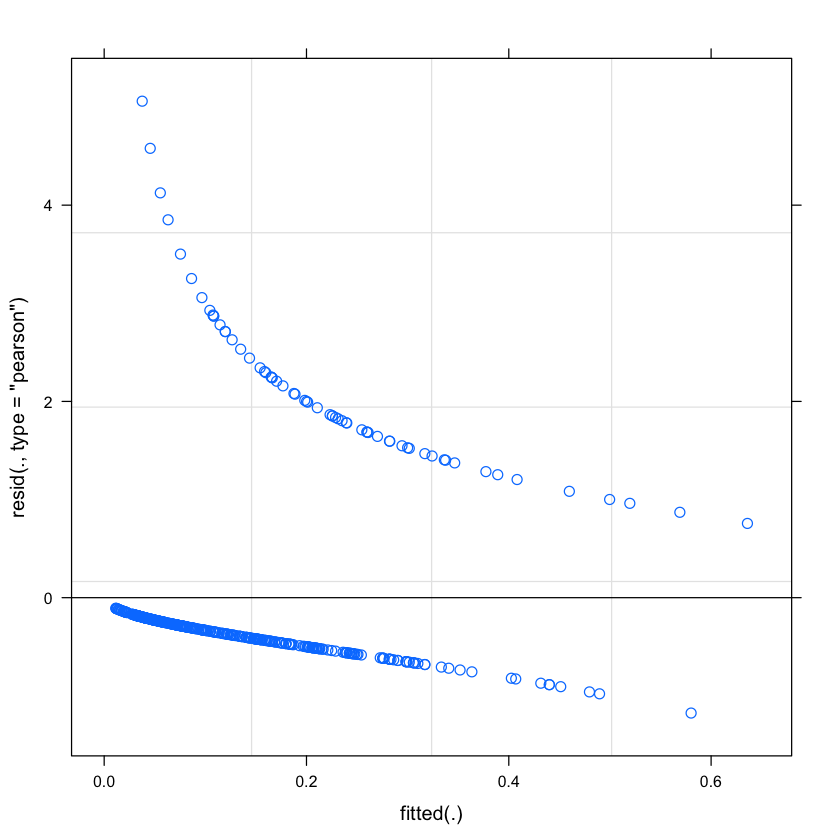

In [58]:
plot(md)  # looks alright, no patterns evident

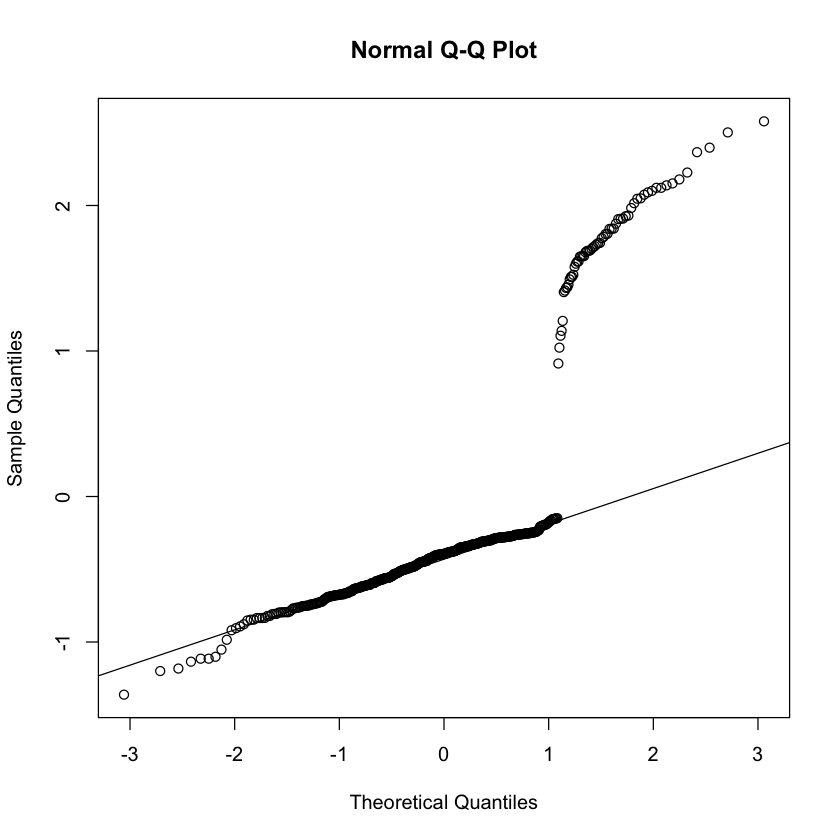

In [55]:
qqnorm(resid(md))
qqline(resid(md))  # points fall nicely onto the line - good!

In [27]:
se <- sqrt(diag(vcov(md)))
# table of estimates with 95% CI
(tab <- cbind(Est = fixef(md), LL = fixefmdm) - 1.96 * se, UL = fixef(md) + 1.96 *
    se)

ERROR: Error in parse(text = x, srcfile = src): <text>:3:58: unexpected ','
2: # table of estimates with 95% CI
3: (tab <- cbind(Est = fixef(md), LL = fixefmdm) - 1.96 * se,
                                                            ^
